In [2]:
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import sympy as sm
import func

In [4]:
# Parameters
#Micro:
theta = 0.9
beta = 0.99
rho = 0.5
#Macro:
alpha = 1/3
delta = 0.05
n = 0.01

# produktion:
b = 1
k0 = 10
l0 = 1

In [6]:
t = 40

In [8]:
times = 20
ks = np.linspace(0.1,100,times)
sks = np.empty(times)
for i,k in enumerate(ks):
    sks[i] = func.optimal_sks(t, b, l0, n, beta, delta, alpha, theta, k)
    

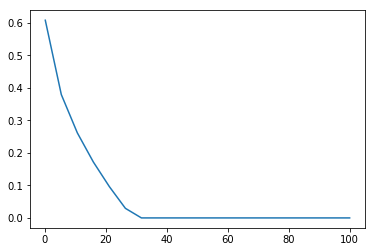

In [9]:
func.plot(ks,sks)

# Solowwalk

With fixed savings rate

In [11]:
def capitalakku(b,k,l,sk,alpha,delta):
    return func.prod(k,l,alpha,b)*sk+(1-delta)*k

In [14]:
def solowwalk(k0, b, l0, n, sk, alpha, delta, theta,t_big):
    k_path = np.array([k0])
    l_path = np.array([l0*(1+n)**i for i in list(range(t_big))])
    y_path = np.array([func.prod(k_path[0],l_path[0],alpha,b)])
    
    for i in range(1,t_big):
        k_plus = capitalakku(b,k_path[i-1],l_path[i-1],sk,alpha,delta)
        y_plus = func.prod(k_plus,l_path[i-1],alpha,b)
        
        k_path = np.append(k_path, k_plus)
        y_path = np.append(y_path, y_plus)
        
    k_pr_path = k_path/l_path   
    y_pr_path = y_path/l_path                      
    return y_path, k_path, k_pr_path, y_pr_path

In [16]:
t_big = 150
sk = alpha

In [18]:
y_path, k_path, k_pr_path, y_pr_path = solowwalk(k0, b, l0, n, sk, alpha, delta, theta,t_big)
k_pr_path[-1]

13.086713164710863

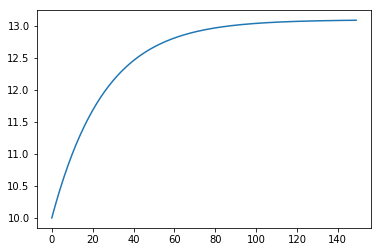

In [19]:
func.plot(range(t_big),k_pr_path)

**Finding steady state for given savings rate:**

\\[
Y=B \cdot K^{\alpha} \cdot L^{1-\alpha} \Leftrightarrow y=B k^{\alpha}
\\]
\\[
K_{t+1}=s_{Kt} \cdot Y_{t} + \left(1-\delta\right)K_{t}
\\]
\\[
k_{t+1}=\frac{1}{1+n} \left(s_{Kt} B k^{\alpha} + \left(1-\delta\right)k_{t}\right)
\\]
Steady state implies:
\\[
k_{t+1}=k_{t}
\\]
Inserting gives:
\\[
k_{t}=\frac{1}{1+n} \left(s_{Kt} B k^{\alpha} + \left(1-\delta\right)k_{t}\right)
\\]
\\[
1=\frac{1}{1+n} \left(s_{Kt} B k^{\alpha -1} + \left(1-\delta\right)\right)
\\]
\\[
n+\delta = s_{Kt} B k^{\alpha -1}
\\]

In [76]:
sm.init_printing(use_unicode=True)

In [78]:
sk = sm.symbols('s_Kt')
# Ud fra de valg nogle udfald
# Først defineres variable
alpha = sm.symbols('alpha')
k =sm.symbols('k_{t}')
delta = sm.symbols('delta')
k_star = sm.symbols('k^{*}')
n = sm.symbols('n')
b = sm.symbols('B')

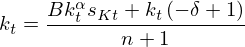

In [80]:
sseq = sm.Eq(k,1/(1+n)*(sk*b*k**alpha+(1-delta)*k))
sseq

In [85]:
ss_sk = sm.solve(sseq,sk)[0]
ss_k = sm.solve(sseq,k)[0]

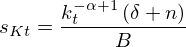

In [84]:
sm.Eq(sk,ss_sk)

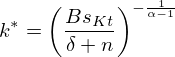

In [86]:
sm.Eq(k_star,ss_k)

In [88]:
find_ssk_sk = sm.lambdify((k,b,delta,n,alpha),ss_sk)
find_ssk_k = sm.lambdify((sk,b,delta,n,alpha),ss_k)

In [90]:
sm.init_printing(use_unicode=False)

In [192]:
# Parameters
#Micro:
theta = 0.3
beta = 0.99
rho = 0.5
#Macro:
alpha = 1/3
delta = 0.05
n = 0.01

# produktion:
b = 1
k0 = 10
l0 = 1

In [194]:
find_ssk_sk(k0,b,delta,n,alpha)

In [196]:
find_ssk_k(0.2784953300167668,b,delta,n,alpha)

In [253]:
times = 30
ks = np.linspace(0.1,30,times)
sks = np.empty(times)
for i,k in enumerate(ks):
    sks[i] = func.optimal_sks(t, b, 1, n, beta, delta, alpha, theta, k)

In [255]:
sksopt = find_ssk_sk(ks,b,delta,n,alpha)

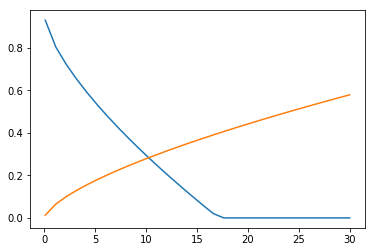

In [256]:
func.plot2(ks,sks,sksopt)

In [279]:
def find_ss(t, b, n, beta, delta, alpha, theta,bracket):
    obj = lambda k_star: find_ssk_sk(k_star,b,delta,n,alpha)-func.optimal_sks(t, b, 1, n, beta, delta, alpha, theta, k_star)
    res = optimize.root_scalar(obj,method='brentq',bracket=bracket)
    if res.converged:
        k_star = res.root
        sk_star = find_ssk_sk(k_star,b,delta,n,alpha)
        return k_star,sk_star
    else:
        print('Convergence failed')
    

In [281]:
bracket =[0,100]

In [282]:
find_ss(100, b, n, beta, delta, alpha, theta, bracket)

**With changing savings rate**

In [286]:
def mod_solowwalk(k0, b, l0, n, alpha, delta, rho, beta,theta, t, t_big):
    k_path = np.array([k0])
    l_path = np.array([l0*(1+n)**i for i in list(range(t_big))])
    y_path = np.array([func.prod(k_path[0],l_path[0],alpha,b)])
    
    sk_path = np.array([func.optimal_sks(
        t, b, l_path[0], n, beta, delta, alpha, theta, k_path[0])])
    
    for i in range(1,t_big):
        k_plus = capitalakku(b,k_path[i-1],l_path[i-1],sk_path[i-1],alpha,delta)
        y_plus = func.prod(k_plus,l_path[i-1],alpha,b)
        sk_plus = np.array([func.optimal_sks(t, b, l_path[i], n, beta, delta, alpha, theta, k_plus)])
        
        k_path = np.append(k_path, k_plus)
        y_path = np.append(y_path, y_plus)
        sk_path = np.append(sk_path,sk_plus)
        
    k_pr_path = k_path/l_path   
    y_pr_path = y_path/l_path                      
    return y_path, k_path, k_pr_path, y_pr_path, sk_path

In [288]:
t_big = 150

In [290]:
y_path, k_path, k_pr_path, y_pr_path, sk_path = mod_solowwalk(
    k0, b, l0, n, alpha, delta, rho, beta,theta, t, t_big)

In [296]:
brakcet = [0,30]

In [298]:
k_star,sk_star = find_ss(t, b, n, beta, delta, alpha, theta, bracket)

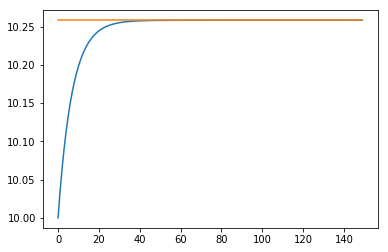

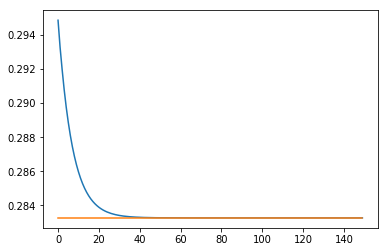

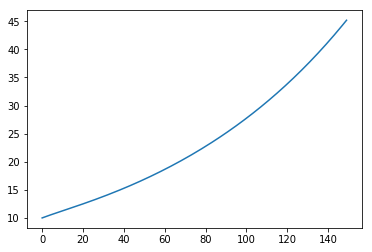

In [299]:
func.plot2(range(t_big),k_pr_path,np.full(t_big,k_star))
func.plot2(range(t_big), sk_path,np.full(t_big,sk_star))
func.plot(range(t_big), k_path)

In [64]:
# capital savingsrate in ss.
sk_path[-1]

In [65]:
# Capital pr. worker in ss.
k_pr_path[-1]

# Speed

In [160]:
import time
%load_ext line_profiler

In [164]:
%timeit mod_solowwalk(k0, b, l0, n, alpha, delta, rho, beta,theta, t, t_big)

1.77 s ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [163]:
%lprun -f mod_solowwalk mod_solowwalk(k0, b, l0, n, alpha, delta, rho, beta,theta, t, t_big)


Timer unit: 1e-06 s

Total time: 2.58089 s
File: <ipython-input-162-ec0801b7b8f7>
Function: mod_solowwalk at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def mod_solowwalk(k0, b, l0, n, alpha, delta, rho, beta,theta, t, t_big):
     2         1         19.0     19.0      0.0      k_path = np.array([k0])
     3         1         89.0     89.0      0.0      l_path = np.array([l0*(1+n)**i for i in list(range(t_big))])
     4         1         68.0     68.0      0.0      y_path = np.array([func.prod(k_path[0],l_path[0],alpha,b)])
     5                                               
     6         1          2.0      2.0      0.0      sk_path = np.array([func.optimal_sks(
     7         1     128046.0 128046.0      5.0          t, b, l_path[0], n, beta, delta, alpha, theta, k_path[0])])
     8                                               
     9        50         57.0      1.1      0.0      for i in range(1,t_big):